<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [37]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [38]:
response = requests.get(url)
response

<Response [200]>

In [39]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [40]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [41]:
keys = ['contacts', 'querents', 'patients_summary']

In [42]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-11-28 17:00:00+09:00,590,0,561,2020-11-28 17:00:00+09:00
2020-11-29 17:00:00+09:00,496,0,418,2020-11-29 17:00:00+09:00
2020-11-30 17:00:00+09:00,510,0,311,2020-11-30 17:00:00+09:00
2020-12-01 17:00:00+09:00,456,0,372,2020-12-01 17:00:00+09:00


In [43]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-11-28 17:00:00+09:00,590,0,561,2020-11-28 17:00:00+09:00,557.714286,3904.0,0.0,0.0,414.857143,2904.0
2020-11-29 17:00:00+09:00,496,0,418,2020-11-29 17:00:00+09:00,539.714286,3778.0,0.0,0.0,418.714286,2931.0
2020-11-30 17:00:00+09:00,510,0,311,2020-11-30 17:00:00+09:00,517.857143,3625.0,0.0,0.0,418.285714,2928.0
2020-12-01 17:00:00+09:00,456,0,372,2020-12-01 17:00:00+09:00,503.571429,3525.0,0.0,0.0,444.857143,3114.0
2020-12-02 17:00:00+09:00,0,0,500,2020-12-02 17:00:00+09:00,436.142857,3053.0,0.0,0.0,459.000000,3213.0


In [44]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-11-18 17:00:00+09:00,546,0,485,2020-11-18 17:00:00+09:00,440.714286,3085.0,0.0,0.0,333.714286,2336.0,'20w47,Wed
2020-11-19 17:00:00+09:00,561,0,533,2020-11-19 17:00:00+09:00,466.571429,3266.0,0.0,0.0,353.857143,2477.0,'20w47,Thu
2020-11-20 17:00:00+09:00,608,0,522,2020-11-20 17:00:00+09:00,482.428571,3377.0,0.0,0.0,375.000000,2625.0,'20w47,Fri
2020-11-21 17:00:00+09:00,730,0,539,2020-11-21 17:00:00+09:00,530.285714,3712.0,0.0,0.0,401.714286,2812.0,'20w47,Sat
2020-11-22 17:00:00+09:00,622,0,391,2020-11-22 17:00:00+09:00,563.285714,3943.0,0.0,0.0,421.142857,2948.0,'20w47,Sun
2020-11-23 17:00:00+09:00,663,0,314,2020-11-23 17:00:00+09:00,588.714286,4121.0,0.0,0.0,440.285714,3082.0,'20w48,Mon
2020-11-24 17:00:00+09:00,556,0,186,2020-11-24 17:00:00+09:00,612.285714,4286.0,0.0,0.0,424.285714,2970.0,'20w48,Tue
2020-11-25 17:00:00+09:00,472,0,401,2020-11-25 17:00:00+09:00,601.714286,4212.0,0.0,0.0,412.285714,2886.0,'20w48,Wed
2020-11-26 17:00:00+09:00,484,0,481,2020-11-26 17:00:00+09:00,590.714286,4135.0,0.0,0.0,404.857143,2834.0,'20w48,Thu
2020-11-27 17:00:00+09:00,517,0,570,2020-11-27 17:00:00+09:00,577.714286,4044.0,0.0,0.0,411.714286,2882.0,'20w48,Fri


In [45]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [46]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-11-08 17:00:00+09:00,201.714286,1412
2020-11-15 17:00:00+09:00,305.571429,2139
2020-11-22 17:00:00+09:00,421.142857,2948
2020-11-29 17:00:00+09:00,418.714286,2931
2020-12-02 17:00:00+09:00,394.333333,1183


In [47]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-11-18 17:00:00+09:00,546,0,485,2020-11-18 17:00:00+09:00,440.714286,3085.0,0.0,0.0,333.714286,2336.0,'20w47,Wed,NaN,NaN
2020-11-19 17:00:00+09:00,561,0,533,2020-11-19 17:00:00+09:00,466.571429,3266.0,0.0,0.0,353.857143,2477.0,'20w47,Thu,NaN,NaN
2020-11-20 17:00:00+09:00,608,0,522,2020-11-20 17:00:00+09:00,482.428571,3377.0,0.0,0.0,375.000000,2625.0,'20w47,Fri,NaN,NaN
2020-11-21 17:00:00+09:00,730,0,539,2020-11-21 17:00:00+09:00,530.285714,3712.0,0.0,0.0,401.714286,2812.0,'20w47,Sat,NaN,NaN
2020-11-22 17:00:00+09:00,622,0,391,2020-11-22 17:00:00+09:00,563.285714,3943.0,0.0,0.0,421.142857,2948.0,'20w47,Sun,421.142857,2948.0
2020-11-23 17:00:00+09:00,663,0,314,2020-11-23 17:00:00+09:00,588.714286,4121.0,0.0,0.0,440.285714,3082.0,'20w48,Mon,NaN,NaN
2020-11-24 17:00:00+09:00,556,0,186,2020-11-24 17:00:00+09:00,612.285714,4286.0,0.0,0.0,424.285714,2970.0,'20w48,Tue,NaN,NaN
2020-11-25 17:00:00+09:00,472,0,401,2020-11-25 17:00:00+09:00,601.714286,4212.0,0.0,0.0,412.285714,2886.0,'20w48,Wed,NaN,NaN
2020-11-26 17:00:00+09:00,484,0,481,2020-11-26 17:00:00+09:00,590.714286,4135.0,0.0,0.0,404.857143,2834.0,'20w48,Thu,NaN,NaN
2020-11-27 17:00:00+09:00,517,0,570,2020-11-27 17:00:00+09:00,577.714286,4044.0,0.0,0.0,411.714286,2882.0,'20w48,Fri,NaN,NaN


### グラフ出力

In [48]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [49]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

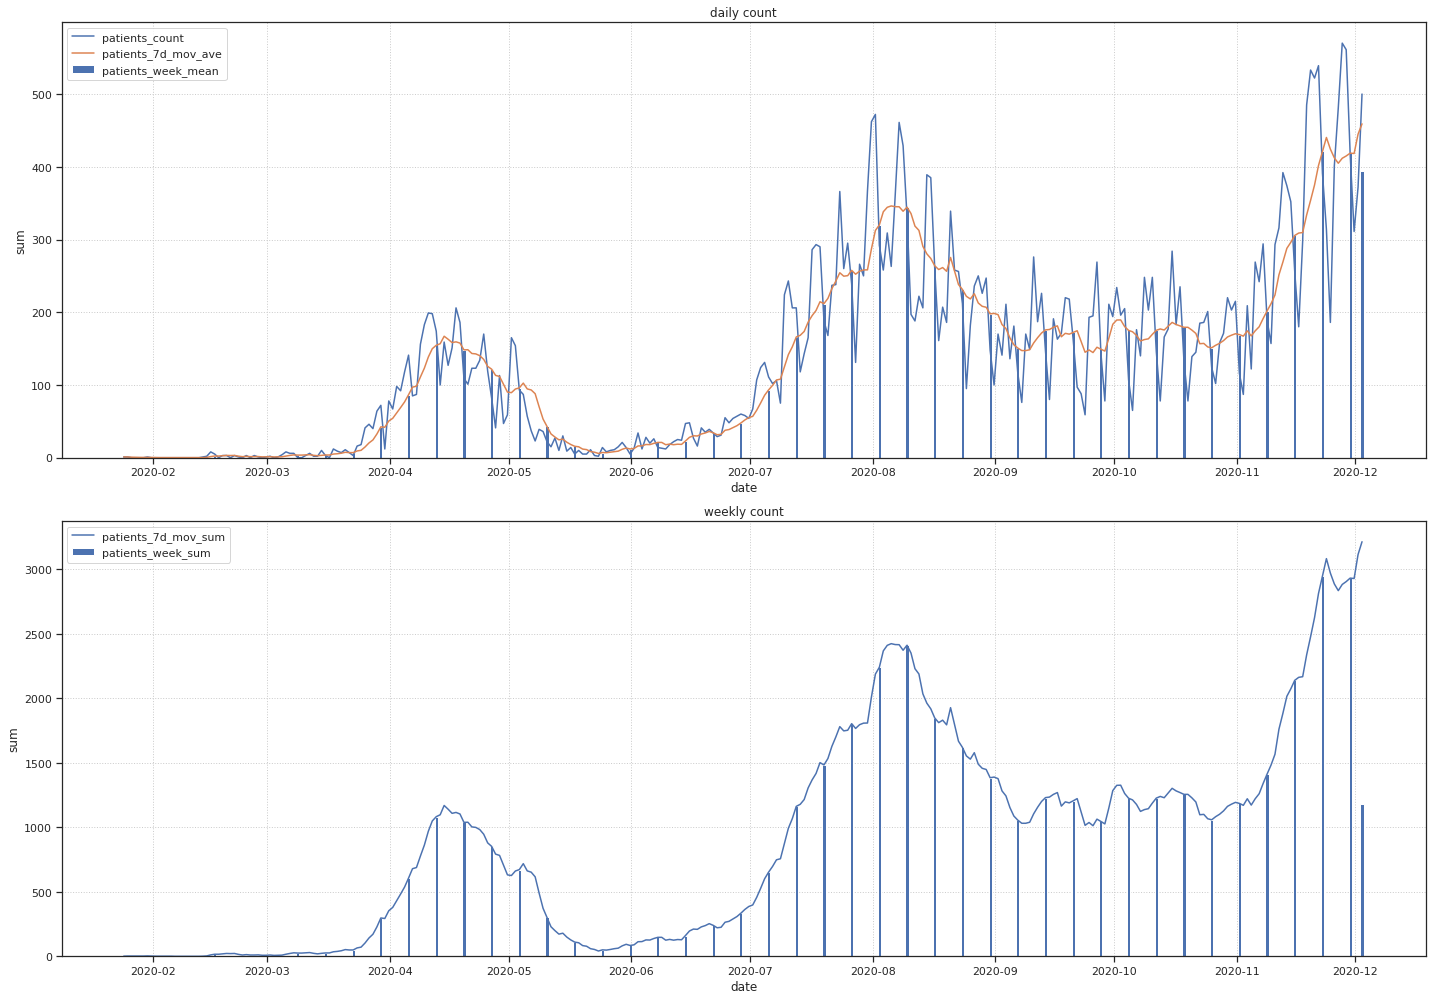

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [51]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [52]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [53]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [54]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [55]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
299,1.605686e+09,2020,11,18,0,0,0,0,0,0,1,299,0,225,546,440.714286,3085.0,0,0.0,0.0,485,333.714286,2336.0
300,1.605773e+09,2020,11,19,0,0,0,0,1,0,0,300,0,226,561,466.571429,3266.0,0,0.0,0.0,533,353.857143,2477.0
301,1.605859e+09,2020,11,20,1,0,0,0,0,0,0,301,0,227,608,482.428571,3377.0,0,0.0,0.0,522,375.000000,2625.0
302,1.605946e+09,2020,11,21,0,0,1,0,0,0,0,302,0,228,730,530.285714,3712.0,0,0.0,0.0,539,401.714286,2812.0
303,1.606032e+09,2020,11,22,0,0,0,1,0,0,0,303,0,229,622,563.285714,3943.0,0,0.0,0.0,391,421.142857,2948.0
304,1.606118e+09,2020,11,23,0,1,0,0,0,0,0,304,0,230,663,588.714286,4121.0,0,0.0,0.0,314,440.285714,3082.0
305,1.606205e+09,2020,11,24,0,0,0,0,0,1,0,305,0,231,556,612.285714,4286.0,0,0.0,0.0,186,424.285714,2970.0
306,1.606291e+09,2020,11,25,0,0,0,0,0,0,1,306,0,232,472,601.714286,4212.0,0,0.0,0.0,401,412.285714,2886.0
307,1.606378e+09,2020,11,26,0,0,0,0,1,0,0,307,0,233,484,590.714286,4135.0,0,0.0,0.0,481,404.857143,2834.0
308,1.606464e+09,2020,11,27,1,0,0,0,0,0,0,308,0,234,517,577.714286,4044.0,0,0.0,0.0,570,411.714286,2882.0


In [56]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            314 non-null    float64
 1   year                 314 non-null    int64  
 2   month                314 non-null    int64  
 3   day                  314 non-null    int64  
 4   Fri                  314 non-null    uint8  
 5   Mon                  314 non-null    uint8  
 6   Sat                  314 non-null    uint8  
 7   Sun                  314 non-null    uint8  
 8   Thu                  314 non-null    uint8  
 9   Tue                  314 non-null    uint8  
 10  Wed                  314 non-null    uint8  
 11  passed               314 non-null    int64  
 12  emergency            314 non-null    int64  
 13  em_passed            314 non-null    int64  
 14  contacts_count       314 non-null    int64  
 15  contacts_7d_mov_ave  314 non-null    flo

In [57]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.140000e+02,314.0,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,1.593374e+09,2020.0,6.410828,15.917197,0.143312,0.143312,0.143312,0.143312,0.140127,0.143312,0.143312,156.500000,0.156051,91.337580,755.611465,752.198741,5265.378981,1171.105096,1171.105096,8197.735669,133.156051,129.046087,903.270701
std,7.844102e+06,0.0,2.982378,8.936740,0.350950,0.350950,0.350950,0.350950,0.347673,0.350950,0.350950,90.788215,0.363483,79.126183,480.021434,467.551217,3272.878127,835.150224,678.430183,4749.011279,129.405292,115.666690,809.724680
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.586614e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.250000,0.000000,4.250000,450.000000,453.250000,3172.750000,393.500000,886.035714,6202.250000,14.000000,16.178571,113.250000
50%,1.593374e+09,2020.0,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156.500000,0.000000,82.500000,602.500000,612.785714,4289.500000,1208.500000,1196.071429,8372.500000,108.000000,142.214286,995.500000
75%,1.600135e+09,2020.0,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.750000,0.000000,160.750000,906.750000,920.392857,6442.750000,1751.750000,1656.142857,11593.000000,206.000000,183.357143,1283.500000
max,1.606896e+09,2020.0,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,313.000000,1.000000,239.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,570.000000,459.000000,3213.000000


In [58]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,NaN,0.995152,0.026710,-0.011281,0.002256,-0.006768,-0.002256,-2.182083e-18,0.006768,0.011281,1.000000e+00,-0.277520,0.984271,-0.089826,-0.051469,-0.051462,0.037730,0.103669,0.103669,0.716822,0.777417,0.777471
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.951519e-01,NaN,1.000000,-0.071601,-0.013697,0.001565,-0.007592,-0.001487,-2.355067e-04,0.007670,0.013775,9.951519e-01,-0.274474,0.978276,-0.085734,-0.048209,-0.048202,0.041458,0.110127,0.110127,0.713066,0.772773,0.772835
day,2.670969e-02,NaN,-0.071601,1.000000,0.025188,0.006852,0.007870,-0.007410,2.718027e-03,-0.009447,-0.025746,2.670969e-02,-0.010763,0.032344,-0.016019,-0.006566,-0.006571,-0.018040,-0.042719,-0.042719,0.020728,0.027849,0.027780
Fri,-1.128063e-02,NaN,-0.013697,0.025188,1.000000,-0.167286,-0.167286,-0.167286,-1.651105e-01,-0.167286,-0.167286,-1.128063e-02,-0.000558,-0.009341,-0.014821,-0.004819,-0.004818,0.050254,-0.002245,-0.002245,0.087513,-0.011182,-0.011222
Mon,2.256126e-03,NaN,0.001565,0.006852,-0.167286,1.000000,-0.167286,-0.167286,-1.651105e-01,-0.167286,-0.167286,2.256126e-03,-0.000558,0.002394,0.050323,-0.000380,-0.000378,0.234581,-0.002245,-0.002245,-0.163211,0.003272,0.003281
Sat,-6.768377e-03,NaN,-0.007592,0.007870,-0.167286,-0.167286,1.000000,-0.167286,-1.651105e-01,-0.167286,-0.167286,-6.768377e-03,-0.000558,-0.005429,0.038622,-0.003178,-0.003177,-0.272051,-0.002245,-0.002245,0.108899,-0.004886,-0.004915
Sun,-2.256126e-03,NaN,-0.001487,-0.007410,-0.167286,-0.167286,-0.167286,1.000000,-1.651105e-01,-0.167286,-0.167286,-2.256126e-03,-0.000558,-0.001518,-0.011256,-0.001799,-0.001797,-0.250697,-0.002245,-0.002245,-0.047417,-0.000212,-0.000216
Thu,-2.182083e-18,NaN,-0.000236,0.002718,-0.165110,-0.165110,-0.165110,-0.165110,1.000000e+00,-0.165110,-0.165110,3.595963e-19,0.003382,-0.002770,-0.005110,0.008468,0.008469,0.081549,0.013597,0.013597,0.088917,-0.007572,-0.007546
Tue,6.768377e-03,NaN,0.007670,-0.009447,-0.167286,-0.167286,-0.167286,-0.167286,-1.651105e-01,1.000000,-0.167286,6.768377e-03,-0.000558,0.006306,-0.029671,0.000888,0.000890,0.093235,-0.002245,-0.002245,-0.047346,0.007446,0.007463


---

In [59]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [60]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,1.606550e+09,0,0,1,0,0,0,0,309,0,235,590,0,561,414.857143,2904.0
310,1.606637e+09,0,0,0,1,0,0,0,310,0,236,496,0,418,418.714286,2931.0
311,1.606723e+09,0,1,0,0,0,0,0,311,0,237,510,0,311,418.285714,2928.0
312,1.606810e+09,0,0,0,0,0,1,0,312,0,238,456,0,372,444.857143,3114.0


In [61]:
import seaborn as sns

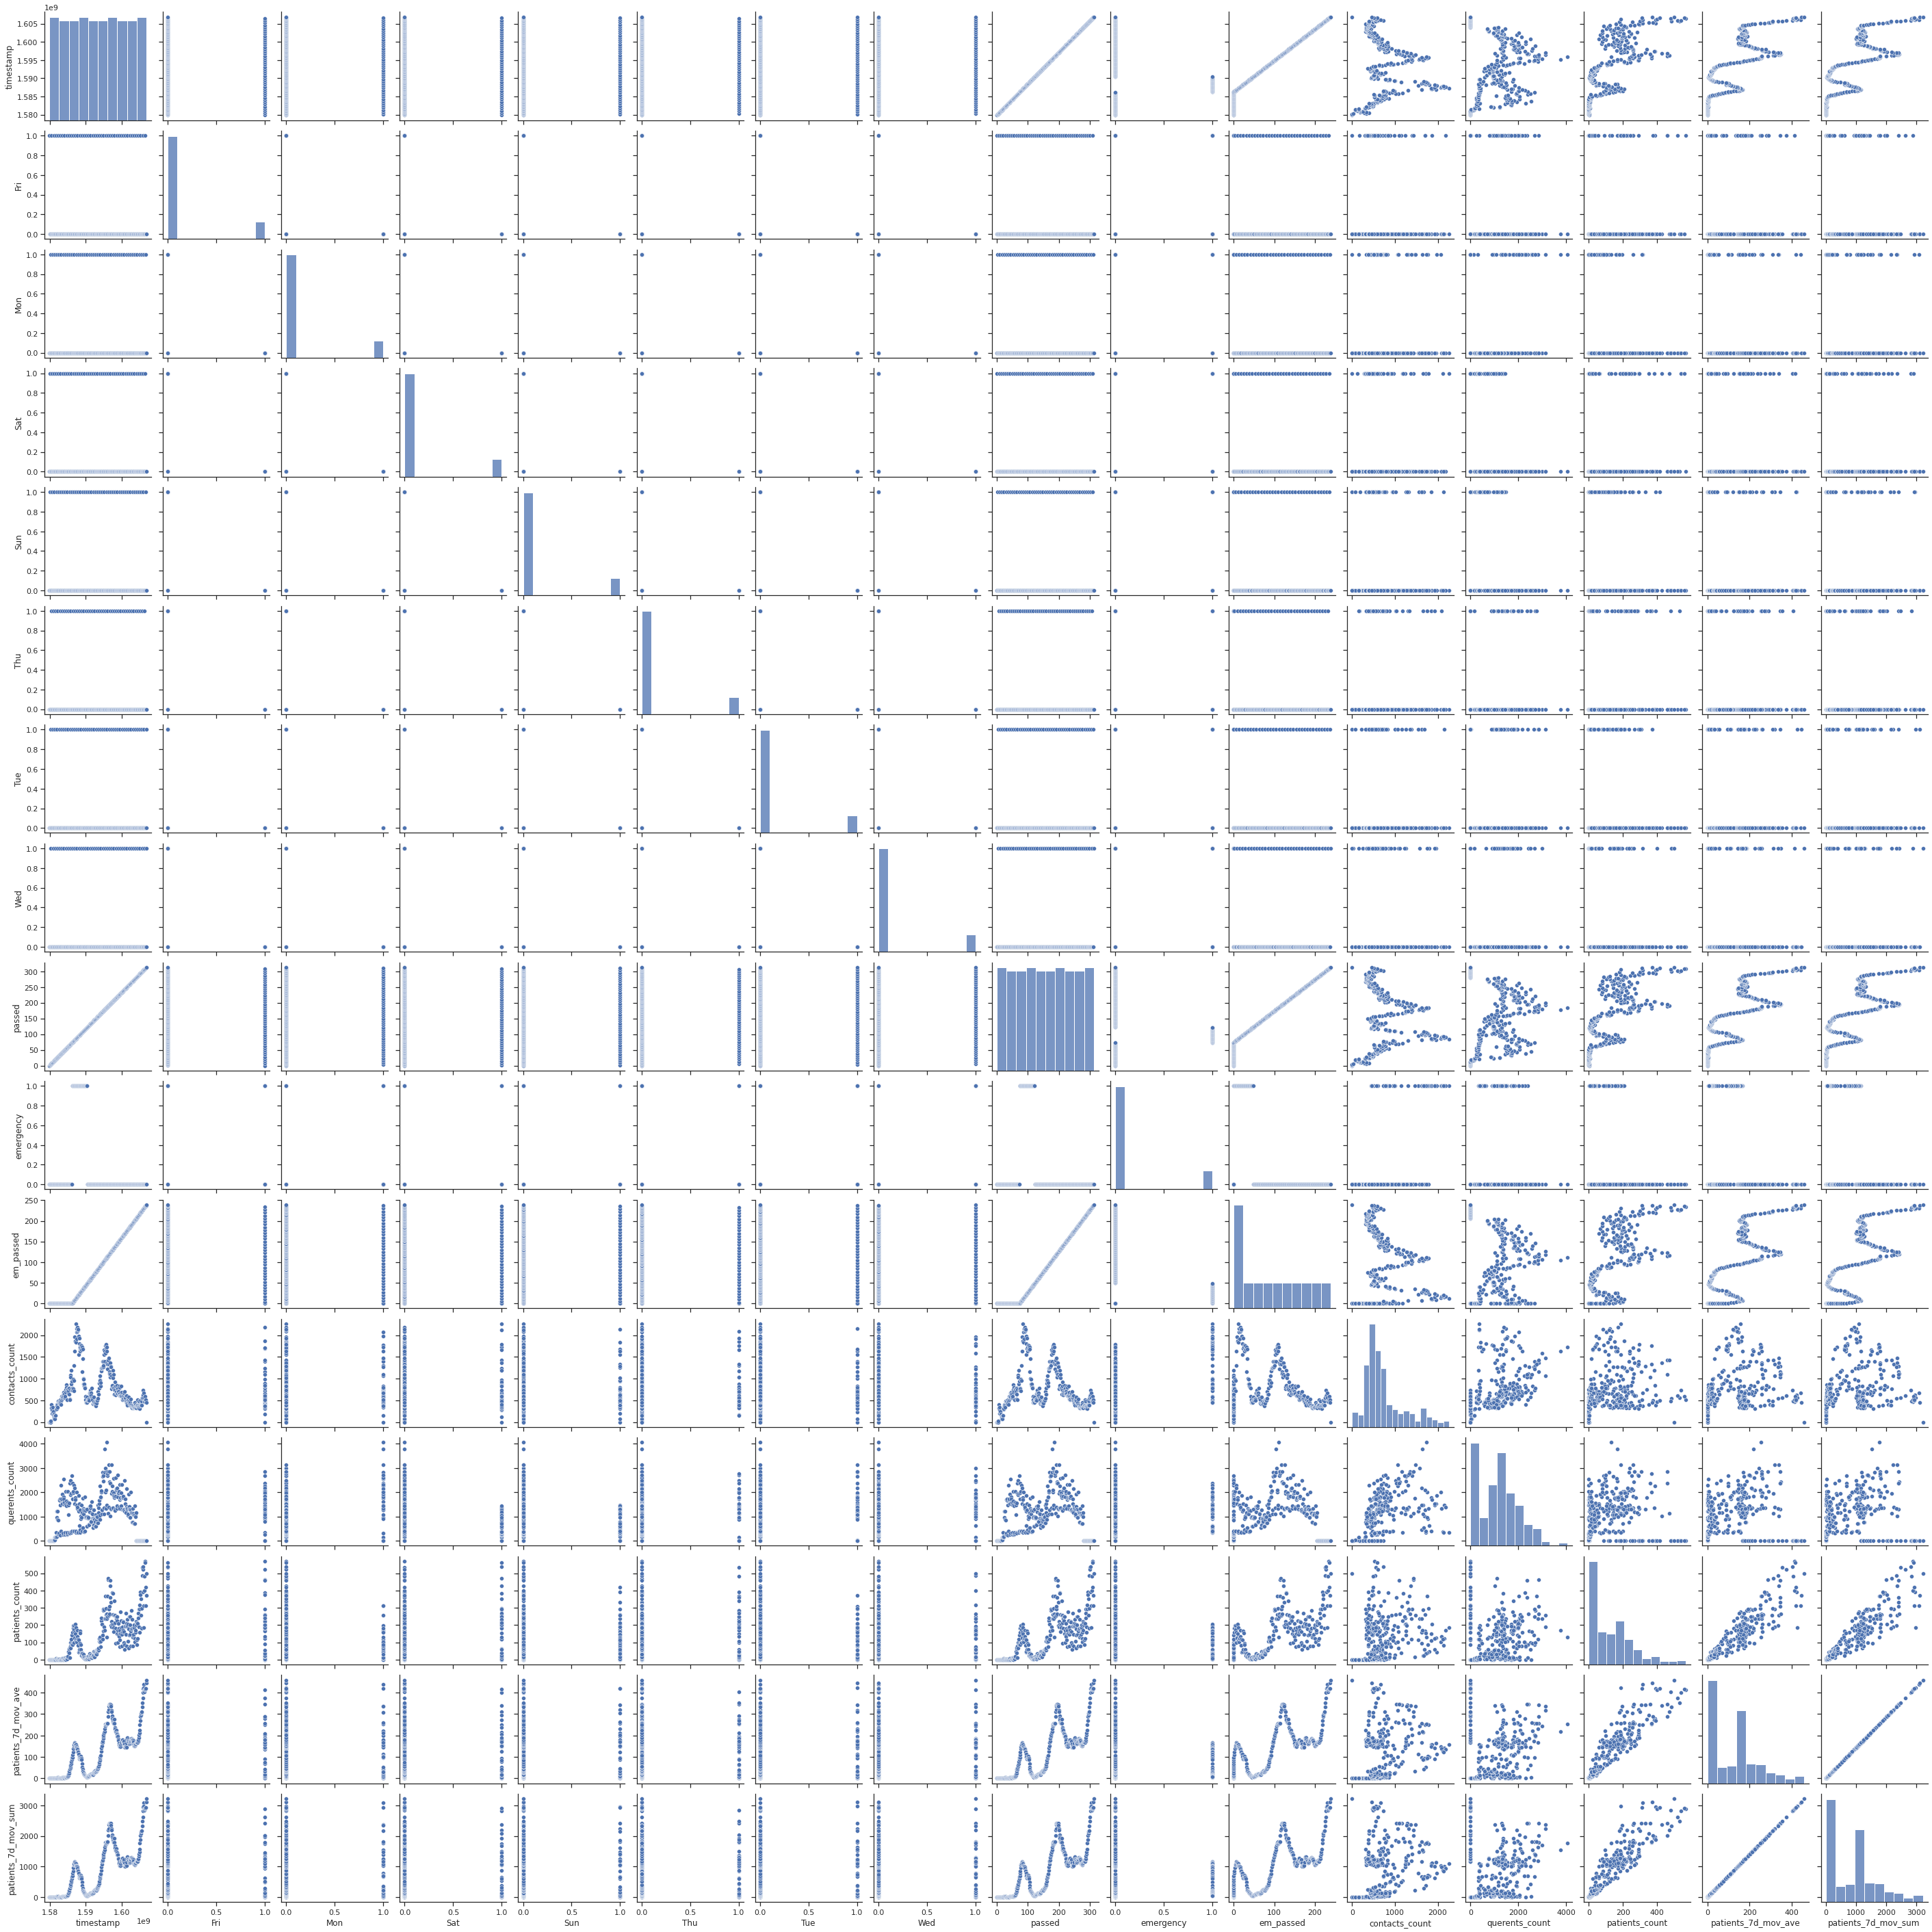

In [62]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [63]:
!python -V

Python 3.6.9
